In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df_true  = pd.read_csv('True.csv')
df_fake  = pd.read_csv('Fake.csv')

In [46]:
df_true['label'] = 1
df_fake['label'] = 0

In [47]:
df = pd.concat([df_true,df_fake],ignore_index=True)

In [48]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [49]:
df.dtypes

title      object
text       object
subject    object
date       object
label       int64
dtype: object

In [52]:
df['label'] = df['label'].astype(int)

In [33]:
df.dropna(inplace=True)

In [34]:
df.drop(['title','subject','date'] ,axis=1, inplace=True)

In [35]:
df.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [54]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [55]:
len(train), len(val), len(test)

(35918, 4490, 4490)

In [42]:
def df_to_dataset(dataframe, shuffle=True, batch_size=512):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["text"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

# def df_to_dataset(dataframe, shuffle=True, batch_size=32):
#   df = dataframe.copy()
#   labels = dataframe.pop('label')
#   ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
#   if shuffle:
#     ds = ds.shuffle(buffer_size=len(dataframe))
#   ds = ds.batch(batch_size)
#   return ds

In [56]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [39]:
list(train_data)[0]

({'text': <tf.Tensor: shape=(32,), dtype=string, numpy=
  array([b'WASHINGTON (Reuters) - Two leading House Democrats introduced legislation on Tuesday intended to curb corporate tax inversion deals by preventing companies from lowering the effective tax rates of U.S. business operations after moving their headquarters overseas. A bill, authored by the top Democrats on the House Ways and Means and Budget Committees, would limit the ability of newly inverted companies to engage in a tax strategy called \xe2\x80\x9cearnings stripping,\xe2\x80\x9d which the lawmakers said often follows an inversion deal.    Corporate inversions, an issue for anti-establishment voters in this year\xe2\x80\x99s presidential and congressional election campaigns, typically occur when a U.S. company buys a foreign firm and then relocates its headquarters to the foreign company\xe2\x80\x99s home country, if only on paper, in a bid to reduce overall taxes. The Obama administration has taken policy steps to disco

## Embedding + Model


In [57]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [58]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(512, 50), dtype=float32, numpy=
array([[ 0.79476875,  0.28695327,  0.6339412 , ..., -0.21898238,
        -0.49479035,  0.244615  ],
       [ 1.1358101 ,  0.4969203 ,  0.44131362, ..., -0.11828542,
         0.22833906, -0.3626587 ],
       [ 1.0479355 ,  0.1611436 ,  0.03254304, ..., -0.21970323,
        -0.1947471 , -0.06093708],
       ...,
       [ 0.9799793 ,  0.1500292 ,  0.4979023 , ...,  0.11029322,
         0.11470143, -0.13644151],
       [ 0.3511225 ,  0.46538994,  0.02568119, ...,  0.16861767,
        -0.14470051,  0.13008107],
       [ 1.2974858 ,  0.4130566 , -0.16124429, ..., -0.11828053,
        -0.42677692, -0.01708301]], dtype=float32)>

In [59]:
model1 = tf.keras.Sequential()
model1.add(hub_layer)
model1.add(tf.keras.layers.Dense(16, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.4))
model1.add(tf.keras.layers.Dense(16, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.4))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [60]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy','AUC'])

In [61]:
model1.evaluate(train_data)

71/71 [==============================] - 6s 62ms/step - loss: 0.7919 - accuracy: 0.3085 - auc: 0.2377


[0.7919171452522278, 0.3085361123085022, 0.237661212682724]

In [62]:
model1.evaluate(valid_data)

9/9 [==============================] - 1s 57ms/step - loss: 0.7918 - accuracy: 0.3049 - auc: 0.2329


[0.7917680144309998, 0.30489978194236755, 0.23294660449028015]

In [63]:
history1 = model1.fit(train_data, epochs=20, validation_data=valid_data)

Epoch 1/20
71/71 [==============================] - 46s 623ms/step - loss: 0.5044 - accuracy: 0.7550 - auc: 0.8451 - val_loss: 0.1764 - val_accuracy: 0.9639 - val_auc: 0.9913
Epoch 2/20
71/71 [==============================] - 45s 639ms/step - loss: 0.1688 - accuracy: 0.9552 - auc: 0.9876 - val_loss: 0.0493 - val_accuracy: 0.9873 - val_auc: 0.9981
Epoch 3/20
71/71 [==============================] - 45s 628ms/step - loss: 0.0713 - accuracy: 0.9842 - auc: 0.9971 - val_loss: 0.0235 - val_accuracy: 0.9929 - val_auc: 0.9994
Epoch 4/20
71/71 [==============================] - 44s 625ms/step - loss: 0.0368 - accuracy: 0.9929 - auc: 0.9991 - val_loss: 0.0161 - val_accuracy: 0.9955 - val_auc: 0.9996
Epoch 5/20
71/71 [==============================] - 45s 634ms/step - loss: 0.0217 - accuracy: 0.9957 - auc: 0.9996 - val_loss: 0.0112 - val_accuracy: 0.9967 - val_auc: 0.9995
Epoch 6/20
71/71 [==============================] - 45s 641ms/step - loss: 0.0138 - accuracy: 0.9974 - auc: 0.9999 - val_loss

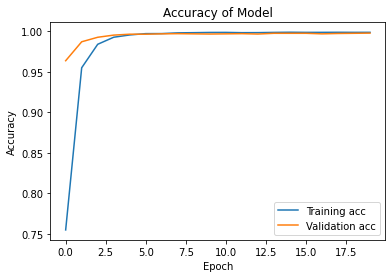

In [64]:
plt.plot(history1.history['accuracy'], label="Training acc")
plt.plot(history1.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of Model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

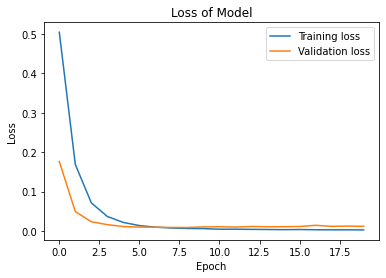

In [65]:
plt.plot(history1.history['loss'], label="Training loss")
plt.plot(history1.history['val_loss'], label="Validation loss")
plt.title("Loss of Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [66]:
model1.evaluate(test_data)

9/9 [==============================] - 1s 96ms/step - loss: 0.0085 - accuracy: 0.9971 - auc: 0.9996


[0.008517567999660969, 0.9971047043800354, 0.9995682239532471]